In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import Compose, ToTensor, RandomAffine

import numpy as np

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, n_latent_features):
        
        super(Encoder, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32*8*8, n_latent_features), nn.ReLU(), nn.BatchNorm1d(n_latent_features),
            nn.Linear(n_latent_features, n_latent_features)
        )
        
    def forward(self, x):
        x = self.conv(x)
        
        x = x.reshape(-1, 32*8*8)
        
        x = self.fc(x)
        
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, n_latent_features):
        
        super(Decoder, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(n_latent_features, 32*8*8), nn.ReLU()
        )
    
        self.conv = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        
        x = x.reshape(-1, 32, 8, 8)
        
        x = self.conv(x)
        
        return x
    
class Autoencoder(nn.Module):
    
    def __init__(self, n_latent_features):
        
        super(Autoencoder, self).__init__()
        
        self.encoder = Encoder(n_latent_features)
        
        self.decoder = Decoder(n_latent_features)
        
    def encode(self, x):
        return self.encoder(x)

    
    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        
        return x

In [3]:
def to_gpu(data):
    if isinstance(data, (list, tuple)):
        return [to_gpu(item) for item in data]
    return data.cuda()

class GPULoader:
    
    def __init__(self, loader):
        self.loader = loader
        
    def __iter__(self):
        for batch in self.loader:
            yield to_gpu(batch)
                
    def __len__(self):
        return len(self.loader)
    
def load_data(root, batch_size, use_gpu):

    preprocessing = []
    augmentations = [RandomAffine(30)]
    postprocessing = [ToTensor()]
    
    train_transofrm = Compose(preprocessing + augmentations + postprocessing)
    test_transofrm = Compose(preprocessing + postprocessing)

    train_dataset = torchvision.datasets.CIFAR10(root=root, train=True,
                                           download=True, transform=train_transofrm)

    test_dataset = torchvision.datasets.CIFAR10(root=root, train=False,
                                           download=True, transform=test_transofrm)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    if use_gpu:
        train_loader = GPULoader(train_loader)
        test_loader = GPULoader(test_loader)
    
    return train_loader, test_loader

In [4]:
def initialize_autoencoder(n_latent_features, use_gpu=True):
    model = Autoencoder(n_latent_features)
    
    if use_gpu:
        model = model.cuda()
        
    return model

def train_epoch(model, optimizer, loader, criterion):

    losses = []

    for x, y in loader:
        model_output = model(x)
        
        loss = criterion(model_output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    mean_loss = np.mean(losses)
    
    return mean_loss


def train_model(model, criterion, optimizer, loader, n_epochs):
    
    for epoch in range(n_epochs):
        mean_loss = train_epoch(model, optimizer, loader, criterion)
        print(f'epoch #{epoch} mean train loss: {mean_loss:.3f}')

In [5]:
import matplotlib.pyplot as plt

def evaluate_model(model, loader):
    
    classes = np.array(('plane', 'car', 'bird', 'cat',
                    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))
    
    max_images = 20
    
    x, y = None, None
    for batch in loader:
        x, y = batch[:max_images]
        
    rec_x = model.decode(model.encode(x))

    x_numpy = x.cpu().detach().numpy()
    rec_x_numpy = rec_x.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    nrows, ncols = len(y), 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

    for i in range(len(y)):
        channel_last_x = np.transpose(x_numpy[i], (1, 2, 0))
        ax[i][0].imshow(channel_last_x)
        ax[i][0].set_title(f'actual {classes[y[i]]}')
        ax[i][0].set_xticks([])
        ax[i][0].set_yticks([])
        
        channel_last_x_rec = np.transpose(rec_x_numpy[i], (1, 2, 0))
        ax[i][1].imshow(channel_last_x_rec)
        ax[i][1].set_title('reconstructed image')
        ax[i][1].set_xticks([])
        ax[i][1].set_yticks([])

In [6]:
image_shape = (3, 32, 32)
batch_size = 128
use_gpu = True
n_epochs = 10
rec_criterion = torch.nn.BCELoss()

In [7]:
train_loader, test_loader = load_data('./data', batch_size, use_gpu)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
model = initialize_autoencoder(
    n_latent_features=16, 
    use_gpu=use_gpu
)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [13]:
train_model(
    model=model, 
    criterion=rec_criterion, 
    optimizer=optimizer,
    loader=train_loader, 
    n_epochs=n_epochs
)

epoch #0 mean train loss: 0.568
epoch #1 mean train loss: 0.550
epoch #2 mean train loss: 0.546
epoch #3 mean train loss: 0.546
epoch #4 mean train loss: 0.545
epoch #5 mean train loss: 0.545
epoch #6 mean train loss: 0.545
epoch #7 mean train loss: 0.544
epoch #8 mean train loss: 0.544
epoch #9 mean train loss: 0.544


In [14]:
model.eval();

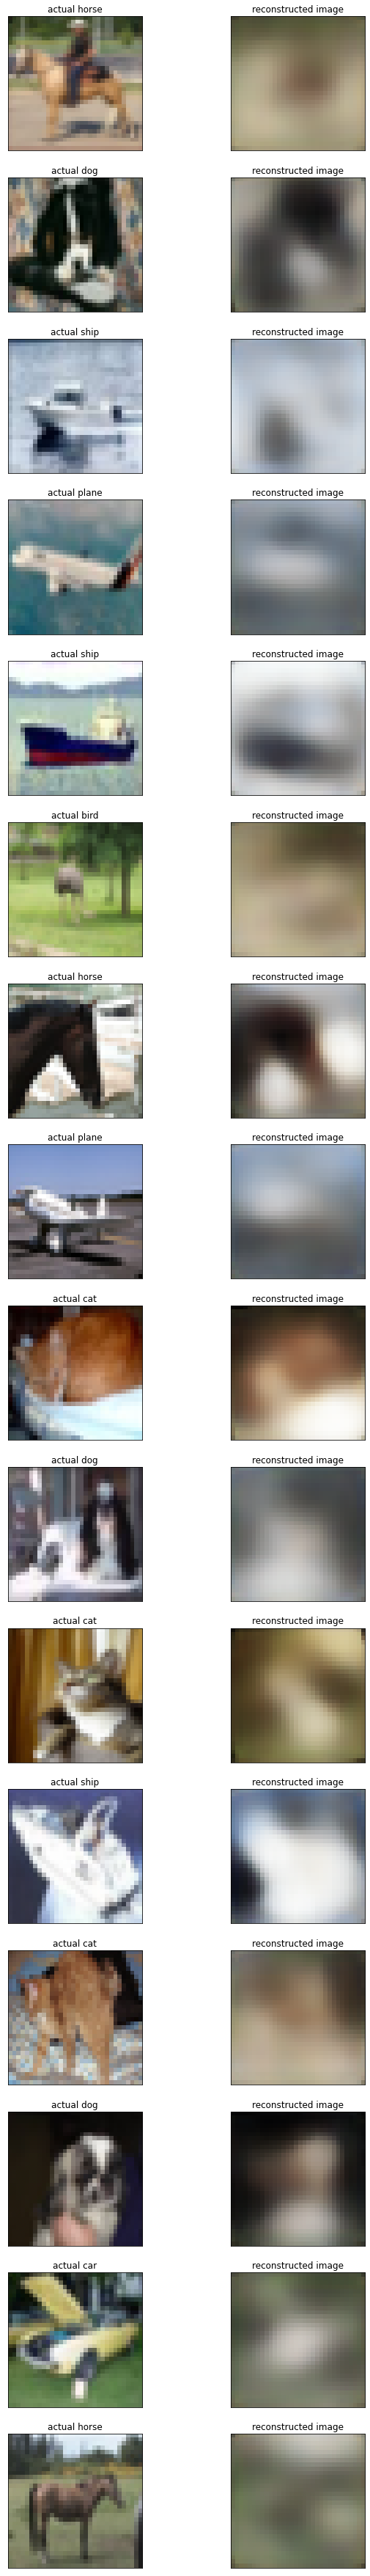

In [15]:
evaluate_model(model, test_loader)